## Importing libraries

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import seaborn as sns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
sns.set()
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, explained_variance_score
from datetime import datetime, timedelta
import pylab
import scipy.stats

In [2]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model 
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2
from pmdarima.arima import auto_arima
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose 
import statsmodels.graphics.tsaplots as sgt

## Importing the Data

In [3]:
btcfile = "btc.csv"
ethfile = 'eth.csv'

btc = pd.read_csv(btcfile)
eth = pd.read_csv(ethfile)

In [4]:
btc.tail()

,date,AdrActCnt,AdrBal1in100KCnt,AdrBal1in100MCnt,AdrBal1in10BCnt,AdrBal1in10KCnt,AdrBal1in10MCnt,AdrBal1in1BCnt,AdrBal1in1KCnt,AdrBal1in1MCnt,AdrBalCnt,AdrBalNtv0.001Cnt,AdrBalNtv0.01Cnt,AdrBalNtv0.1Cnt,AdrBalNtv100Cnt,AdrBalNtv100KCnt,AdrBalNtv10Cnt,AdrBalNtv10KCnt,AdrBalNtv1Cnt,AdrBalNtv1KCnt,AdrBalNtv1MCnt,AdrBalUSD100Cnt,AdrBalUSD100KCnt,AdrBalUSD10Cnt,AdrBalUSD10KCnt,AdrBalUSD10MCnt,AdrBalUSD1Cnt,AdrBalUSD1KCnt,AdrBalUSD1MCnt,AssetEODCompletionTime,BlkCnt,BlkSizeMeanByte,BlkWghtMean,BlkWghtTot,CapAct1yrUSD,CapMVRVCur,CapMVRVFF,CapMrktCurUSD,CapMrktFFUSD,CapRealUSD,DiffLast,DiffMean,FeeByteMeanNtv,FeeMeanNtv,FeeMeanUSD,FeeMedNtv,FeeMedUSD,FeeTotNtv,FeeTotUSD,FlowInExNtv,FlowInExUSD,FlowOutExNtv,FlowOutExUSD,FlowTfrFromExCnt,HashRate,HashRate30d,IssContNtv,IssContPctAnn,IssContPctDay,IssContUSD,IssTotNtv,IssTotUSD,NDF,NVTAdj,NVTAdj90,NVTAdjFF,NVTAdjFF90,PriceBTC,PriceUSD,ROI1yr,ROI30d,RevAllTimeUSD,RevHashNtv,RevHashRateNtv,RevHashRateUSD,RevHashUSD,RevNtv,RevUSD,SER,SplyAct10yr,SplyAct180d,SplyAct1d,SplyAct1yr,SplyAct2yr,SplyAct30d,SplyAct3yr,SplyAct4yr,SplyAct5yr,SplyAct7d,SplyAct90d,SplyActEver,SplyActPct1yr,SplyAdrBal1in100K,SplyAdrBal1in100M,SplyAdrBal1in10B,SplyAdrBal1in10K,SplyAdrBal1in10M,SplyAdrBal1in1B,SplyAdrBal1in1K,SplyAdrBal1in1M,SplyAdrBalNtv0.001,SplyAdrBalNtv0.01,SplyAdrBalNtv0.1,SplyAdrBalNtv1,SplyAdrBalNtv10,SplyAdrBalNtv100,SplyAdrBalNtv100K,SplyAdrBalNtv10K,SplyAdrBalNtv1K,SplyAdrBalNtv1M,SplyAdrBalUSD1,SplyAdrBalUSD10,SplyAdrBalUSD100,SplyAdrBalUSD100K,SplyAdrBalUSD10K,SplyAdrBalUSD10M,SplyAdrBalUSD1K,SplyAdrBalUSD1M,SplyAdrTop100,SplyAdrTop10Pct,SplyAdrTop1Pct,SplyCur,SplyExpFut10yr,SplyFF,SplyMiner0HopAllNtv,SplyMiner0HopAllUSD,SplyMiner1HopAllNtv,SplyMiner1HopAllUSD,TxCnt,TxCntSec,TxTfrCnt,TxTfrValAdjNtv,TxTfrValAdjUSD,TxTfrValMeanNtv,TxTfrValMeanUSD,TxTfrValMedNtv,TxTfrValMedUSD,VelCur1yr,VtyDayRet180d,VtyDayRet30d
4720,2021-12-06,1078373,9491,2271212,16198472,1036,472812,6944550,44,100294,39286031,19171387,9351355,3291529,16149,3,148870,86,813636,2153,0,16006360.0,459647.0,25972160.0,2219033.0,9245.0,34561275.0,6816252.0,98239.0,1638848780,172,1.103169e+06,2.885523e+06,496309983,4.312209e+11,2.067538,1.590903,9.547835e+11,7.346750e+11,4.617974e+11,2.233566e+13,2.233566e+13,7.020700e-08,0.000047,2.351919,0.000013,0.641295,13.321520,673208.674283,40981.345143,2.071010e+09,56544.590183,2.857505e+09,13379,1.909736e+08,1.631800e+08,1075.00,2.076789,0.005690,5.432558e+07,1075.00,5.432558e+07,0.345202,34.018833,51.632636,26.176391,39.729641,1,50535.425223,161.079801,-17.768479,3.670834e+10,6.600000e-11,0.000006,0.287992,0.000003,1088.321520,5.499879e+07,0.082512,1.646947e+07,4.612019e+06,406418.555710,8.533042e+06,1.039870e+07,2.041946e+06,1.175038e+07,1.347955e+07,1.451356e+07,9.932287e+05,3.262346e+06,1.711559e+07,45.164260,1.104456e+07,1.851912e+07,1.888251e+07,6.522020e+06,1.746557e+07,1.881816e+07,2.096703e+06,1.556591e+07,1.888654e+07,1.884913e+07,1.865273e+07,1.788265e+07,1.618667e+07,1.187387e+07,574153.766428,2.620855e+06,7.876342e+06,0,1.889069e+07,1.888997e+07,1.888214e+07,1.744014e+07,1.850904e+07,1.099696e+07,1.881568e+07,1.552630e+07,2.759614e+06,1.870728e+07,1.730384e+07,1.889335e+07,2.063839e+07,1.453782e+07,1.799576e+06,9.094234e+10,2.623279e+06,1.325685e+11,286268,3.313287,848083,555379.131291,2.806632e+10,1.774040,89651.848566,0.002975,150.333288,14.487375,0.036429,0.037229
4721,2021-12-07,983177,9501,2273648,16209029,1037,472957,6955687,43,100322,39309060,19173419,9364618,3295526,16169,3,148732,87,813929,2158,0,16018490.0,460052.0,25983550.0,2222245.0,9261.0,34580130.0,6828353.0,98298.0,1638931861,154,1.188638e+06,3.256767e+06,501542166,4.329549e+11,2.064377,1.588315,9.555699e+11,7.352077e+11,4.628853e+11,2.233566e+13,2.233566e+13,5.887400e-08,0.000038,1.915255,0.000008,0.419768,10.776869,545034.481125,20247.123179,1.023988e+09,34325.245942,1.735981e+09,11482,1.709880e+08,1.633884e+08,962.50,1.859356,0.005094,4.867793e+07,962.50,4.867793e+07,0.344679,50.942501,51.360425,39.194746,39.

## Data PreProcessing - Converting our data to time series


In [5]:
btc.dropna(subset=['PriceUSD'], how='all',inplace= True)      #Dropping Null values from PriceUSD Column
btc.reset_index(inplace=True, drop=True)                       #Index Reset

btc['date'] = pd.to_datetime(btc['date'])          #Converting Date Column to DateTime Object
btc.set_index('date',inplace=True)                  #Setting the date as index for time-series analysis
btc = btc.asfreq('d')                                #Setting frequency to daily

In [6]:
#Adding Log Price of btc
logP = np.log(btc['PriceUSD'])
btc['logbtc'] = logP
#Adding Returns of btc and eth
#btc['returneth'] = btc.ethusd.pct_change(1).mul(100)
btc['returnbtc'] = btc.PriceUSD.pct_change(1).mul(100)
btc['sqreturnbtc'] = btc.returnbtc.mul(btc.returnbtc)
#add a new column category next to the age group. 
category = pd.cut(btc.CapMVRVFF,bins=[0,1.6,200],labels=['Buy','Sell'])
btc.insert(2,'Action',category)
btc['NetFlowExNtv'] = btc.FlowOutExNtv.subtract(btc.FlowInExNtv )

btc = btc.iloc[1:] #Removing the first row as the return value would be null for it.
btc.head()

,AdrActCnt,AdrBal1in100KCnt,Action,AdrBal1in100MCnt,AdrBal1in10BCnt,AdrBal1in10KCnt,AdrBal1in10MCnt,AdrBal1in1BCnt,AdrBal1in1KCnt,AdrBal1in1MCnt,AdrBalCnt,AdrBalNtv0.001Cnt,AdrBalNtv0.01Cnt,AdrBalNtv0.1Cnt,AdrBalNtv100Cnt,AdrBalNtv100KCnt,AdrBalNtv10Cnt,AdrBalNtv10KCnt,AdrBalNtv1Cnt,AdrBalNtv1KCnt,AdrBalNtv1MCnt,AdrBalUSD100Cnt,AdrBalUSD100KCnt,AdrBalUSD10Cnt,AdrBalUSD10KCnt,AdrBalUSD10MCnt,AdrBalUSD1Cnt,AdrBalUSD1KCnt,AdrBalUSD1MCnt,AssetEODCompletionTime,BlkCnt,BlkSizeMeanByte,BlkWghtMean,BlkWghtTot,CapAct1yrUSD,CapMVRVCur,CapMVRVFF,CapMrktCurUSD,CapMrktFFUSD,CapRealUSD,DiffLast,DiffMean,FeeByteMeanNtv,FeeMeanNtv,FeeMeanUSD,FeeMedNtv,FeeMedUSD,FeeTotNtv,FeeTotUSD,FlowInExNtv,FlowInExUSD,FlowOutExNtv,FlowOutExUSD,FlowTfrFromExCnt,HashRate,HashRate30d,IssContNtv,IssContPctAnn,IssContPctDay,IssContUSD,IssTotNtv,IssTotUSD,NDF,NVTAdj,NVTAdj90,NVTAdjFF,NVTAdjFF90,PriceBTC,PriceUSD,ROI1yr,ROI30d,RevAllTimeUSD,RevHashNtv,RevHashRateNtv,RevHashRateUSD,RevHashUSD,RevNtv,RevUSD,SER,SplyAct10yr,SplyAct180d,SplyAct1d,SplyAct1yr,SplyAct2yr,SplyAct30d,SplyAct3yr,SplyAct4yr,SplyAct5yr,SplyAct7d,SplyAct90d,SplyActEver,SplyActPct1yr,SplyAdrBal1in100K,SplyAdrBal1in100M,SplyAdrBal1in10B,SplyAdrBal1in10K,SplyAdrBal1in10M,SplyAdrBal1in1B,SplyAdrBal1in1K,SplyAdrBal1in1M,SplyAdrBalNtv0.001,SplyAdrBalNtv0.01,SplyAdrBalNtv0.1,SplyAdrBalNtv1,SplyAdrBalNtv10,SplyAdrBalNtv100,SplyAdrBalNtv100K,SplyAdrBalNtv10K,SplyAdrBalNtv1K,SplyAdrBalNtv1M,SplyAdrBalUSD1,SplyAdrBalUSD10,SplyAdrBalUSD100,SplyAdrBalUSD100K,SplyAdrBalUSD10K,SplyAdrBalUSD10M,SplyAdrBalUSD1K,SplyAdrBalUSD1M,SplyAdrTop100,SplyAdrTop10Pct,SplyAdrTop1Pct,SplyCur,SplyExpFut10yr,SplyFF,SplyMiner0HopAllNtv,SplyMiner0HopAllUSD,SplyMiner1HopAllNtv,SplyMiner1HopAllUSD,TxCnt,TxCntSec,TxTfrCnt,TxTfrValAdjNtv,TxTfrValAdjUSD,TxTfrValMeanNtv,TxTfrValMeanUSD,TxTfrValMedNtv,TxTfrValMedUSD,VelCur1yr,VtyDayRet180d,VtyDayRet30d,logbtc,returnbtc,sqreturnbtc,NetFlowExNtv
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-07-19,929,49297,Sell,52208,52311,207,51276,52311,54,51085,52311,52311,52311,51351,503,0,49503,23,51248,119,0,103.0,0.0,400.0,0.0,0.0,49409.0,19.0,0.0,1614335314,174,800.310345,3201.241379,557016,83085.000568,62.565130,62.565130,279285.200000,279285.200000,4463.911468,181.543289,181.543289,3.600000e-07,0.000150,0.000012,0.0,0.0,0.05,0.004040,0.0,0.0,0.0,0.0,0,0.001570,0.000494,8700.0,91.870389,0.251700,702.960000,8700.0,702.960000,0.276688,85.889156,NaN,85.889156,NaN,1,0.080800,NaN,NaN,1441.255854,64.125747,5.540465e+06,447669.536617,5.181360,8700.05,702.964040,0.000054,1076742.90,956079.03,39959.37,1028279.71,1076742.90,478922.86,1076742.90,1076742.90,1076742.90,288640.70,714807.07,1076742.90,29.749160,3444906.71,3456498.74,3456500.0,956370.48,3456445.74,3456500.0,787563.72,3456147.86,3456500.0,3456500.0,3456456.09,3456427.72,3448219.01,1004792.01,0.0,600278.71,908421.45,0,3447271.73,994389.08,891732.43,0.0,0.0,0.0,559006.78,0.0,887733.04,1242146.56,1006476.63,3456500.0,17934137.5,3456500.0,2380385.34,192335.135472,3124984.49,252498.746792,334,0.003866,512,40243.73,3251.693384,86.951152,7.025653,2.625,0.212100,1.828863,NaN,NaN,-2.515778,-5.871389,34.473204,0.0
2010-07-20,936,49367,Sell,52344,52456,213,51353,52456,54,51157,52456,52456,52456,51434,515,0,49582,23,51325,122,0,101.0,0.0,412.0,0.0,0.0,49480.0,17.0,0.0,1614335315,181,1090.745856,4362.983425,789700,77335.024009,45.106630,45.106630,259000.404990,259000.404990,5741.958660,181.543289,181.543289,0.000000e+00,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0,0.001633,0.000543,9050.0,95.316761,0.261142,676.358346,9050.0,676.358346,0.277178,215.744281,NaN,215.744281,NaN,1,0.074736,NaN,NaN,2117.614199,64.125379,5.540433e+06,414068.277311,4.792457,9050.00,676.358346,0.000057,1083243.01,962579.14,40439.91,1034779.82,1083243.01,445805.20,1083243.01,1083243.01,1083243.01,216957.73,716407.18,1083243.01,29.859036,3453853.08,3465548.64,3465

In [7]:
btc.to_csv('btcpro.csv')

In [8]:
eth.dropna(subset=['PriceUSD'], how='all',inplace= True)          #Dropping Null values from PriceUSD Column
eth.reset_index(inplace=True, drop=True)                           #Index Reset

eth['date'] = pd.to_datetime(eth['date'])                     #Converting Date Column to DateTime Object
eth.set_index('date',inplace=True)                             #Setting the date as index for time-series analysis
eth = eth.asfreq('d')                                           #Setting frequency to daily

In [9]:
#Adding Log Price of eth
logP = np.log(eth['PriceUSD'])
eth['logeth'] = logP
#Adding Returns of btc and eth
#btc['returneth'] = btc.ethusd.pct_change(1).mul(100)
eth['returneth'] = eth.PriceUSD.pct_change(1).mul(100)
eth['sqreturneth'] = eth.returneth.mul(eth.returneth)
#add a new column category next to the age group. 
category = pd.cut(eth.CapMVRVFF,bins=[0,1.6,200],labels=['Buy','Sell'])
eth.insert(2,'Action',category)
eth['NetFlowExNtv'] = eth.FlowOutExNtv.subtract(eth.FlowInExNtv )

eth = eth.iloc[1:] #Removing the first row as the return value would be null for it.
eth.head()

,AdrActCnt,AdrBal1in100KCnt,Action,AdrBal1in100MCnt,AdrBal1in10BCnt,AdrBal1in10KCnt,AdrBal1in10MCnt,AdrBal1in1BCnt,AdrBal1in1KCnt,AdrBal1in1MCnt,AdrBalCnt,AdrBalNtv0.001Cnt,AdrBalNtv0.01Cnt,AdrBalNtv0.1Cnt,AdrBalNtv100Cnt,AdrBalNtv100KCnt,AdrBalNtv10Cnt,AdrBalNtv10KCnt,AdrBalNtv1Cnt,AdrBalNtv1KCnt,AdrBalNtv1MCnt,AdrBalUSD100Cnt,AdrBalUSD100KCnt,AdrBalUSD10Cnt,AdrBalUSD10KCnt,AdrBalUSD10MCnt,AdrBalUSD1Cnt,AdrBalUSD1KCnt,AdrBalUSD1MCnt,AssetEODCompletionTime,BlkCnt,BlkSizeMeanByte,CapAct1yrUSD,CapMVRVCur,CapMVRVFF,CapMrktCurUSD,CapMrktFFUSD,CapRealUSD,DiffLast,DiffMean,FeeByteMeanNtv,FeeMeanNtv,FeeMeanUSD,FeeMedNtv,FeeMedUSD,FeeTotNtv,FeeTotUSD,FlowInExNtv,FlowInExUSD,FlowOutExNtv,FlowOutExUSD,FlowTfrFromExCnt,GasLmtBlk,GasLmtBlkMean,GasLmtTx,GasLmtTxMean,GasUsedTx,GasUsedTxMean,HashRate,IssContNtv,IssContPctAnn,IssContPctDay,IssContUSD,IssTotNtv,IssTotUSD,NDF,NVTAdj,NVTAdj90,NVTAdjFF,NVTAdjFF90,PriceBTC,PriceUSD,ROI1yr,ROI30d,RevAllTimeUSD,RevHashNtv,RevHashRateNtv,RevHashRateUSD,RevHashUSD,RevNtv,RevUSD,SER,SplyAct10yr,SplyAct180d,SplyAct1d,SplyAct1yr,SplyAct2yr,SplyAct30d,SplyAct3yr,SplyAct4yr,SplyAct5yr,SplyAct7d,SplyAct90d,SplyActEver,SplyActPct1yr,SplyAdrBal1in100K,SplyAdrBal1in100M,SplyAdrBal1in10B,SplyAdrBal1in10K,SplyAdrBal1in10M,SplyAdrBal1in1B,SplyAdrBal1in1K,SplyAdrBal1in1M,SplyAdrBalNtv0.001,SplyAdrBalNtv0.01,SplyAdrBalNtv0.1,SplyAdrBalNtv1,SplyAdrBalNtv10,SplyAdrBalNtv100,SplyAdrBalNtv100K,SplyAdrBalNtv10K,SplyAdrBalNtv1K,SplyAdrBalNtv1M,SplyAdrBalUSD1,SplyAdrBalUSD10,SplyAdrBalUSD100,SplyAdrBalUSD100K,SplyAdrBalUSD10K,SplyAdrBalUSD10M,SplyAdrBalUSD1K,SplyAdrBalUSD1M,SplyAdrTop100,SplyAdrTop10Pct,SplyAdrTop1Pct,SplyCur,SplyExpFut10yr,SplyFF,TxCnt,TxCntSec,TxTfrCnt,TxTfrValAdjNtv,TxTfrValAdjUSD,TxTfrValMeanNtv,TxTfrValMeanUSD,TxTfrValMedNtv,TxTfrValMedUSD,VelCur1yr,VtyDayRet180d,VtyDayRet30d,logeth,returneth,sqreturneth,NetFlowExNtv
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-08-09,1113,5458,Sell,10043,10411,1169,9573,10222,142,8091,10846,10476,10338,10150,7882,115,9523,966,9914,5124,3,8011.0,127.0,9555.0,1059.0,1.0,10031.0,5346.0,5.0,1614334931,5123,618.298068,1.828813e+07,4.880815,4.023108,8.680133e+07,7.154770e+07,1.778419e+07,1741399466631,1.709480e+12,0.000004,0.010609,0.012730,0.001223,0.001468,14.098950,16.918599,534530.534348,6.414313e+05,93926.854767,112711.286452,179,16092122582,3.141152e+06,107096737,80584.452220,38863003,29242.289691,0.101360,27178.28125,13.714062,0.037573,32613.665717,27178.28125,32613.665717,0.848614,70.374072,NaN,58.007209,NaN,0.004505,1.19999,NaN,NaN,66244.149165,3.105048,268276.120316,321928.661618,3.726026,27192.380200,32630.584316,0.000038,1.524024e+07,1.524024e+07,1.482028e+07,1.524024e+07,1.524024e+07,1.524024e+07,1.524024e+07,1.524024e+07,1.524024e+07,1.510582e+07,1.524024e+07,1.524024e+07,21.068954,7.153599e+07,7.233499e+07,7.233504e+07,6.138450e+07,7.233356e+07,7.233504e+07,4.222648e+07,7.229036e+07,7.233504e+07,7.233504e+07,7.233503e+07,7.233487e+07,7.233311e+07,7.227211e+07,3.989918e+07,5.964097e+07,7.124070e+07,1.495730e+07,7.233498e+07,7.233341e+07,7.228412e+07,4.103494e+07,6.051647e+07,1.190146e+07,7.144848e+07,1.682678e+07,3.839918e+07,6.071768e+07,3.919918e+07,7.233504e+07,1.746695e+08,5.962358e+07,1329,0.015382,1266,1.027865e+06,1.233428e+06,921.287176,1105.535399,12.999397,15.599147,0.231687,NaN,NaN,0.182313,0.000000,0.000000,-440603.679581
2015-08-10,1430,5443,Sell,10145,10572,1160,9611,10348,138,8101,11101,10660,10486,10265,7887,113,9555,954,10000,5094,3,8020.0,124.0,9593.0,1047.0,1.0,10133.0,5321.0,5.0,1614334931,5255,631.186108,1.930666e+07,4.623448,3.811280,8.683471e+07,7.158108e+07,1.878138e+07,1948102094734,1.837696e+12,0.000009,0.015300,0.018359,0.001228,0.001474,31.165144,37.397862,879453.046360,1.055335e+06,177970.680799,213563.037252,235,16507086870,3.141215e+06,167506161,82231.792342,74070061,36362.327442,0.111855,27817.34375,14.031135,0.038441,333

In [10]:
eth.to_csv('ethpro.csv')

### Twitter Sentiment Data

In [11]:
btc_s = pd.read_csv('btc_sentiment.csv')
eth_s = pd.read_csv('eth_sentiment.csv')

In [12]:
btc_s = btc_s.rename(columns={"polarity": "btcpolarity", "subjectivity": "btcsubjectivity"})
eth_s = eth_s.rename(columns={"polarity": "ethpolarity", "subjectivity": "ethsubjectivity"})

btc_s.reset_index(inplace=True, drop=True)                           #Index Reset
btc_s['date'] = pd.to_datetime(btc_s['date'])                     #Converting Date Column to DateTime Object
btc_s.set_index('date',inplace=True)                             #Setting the date as index for time-series analysis
btc_s = btc_s.asfreq('d')

eth_s.reset_index(inplace=True, drop=True)                           #Index Reset
eth_s['date'] = pd.to_datetime(eth_s['date'])                     #Converting Date Column to DateTime Object
eth_s.set_index('date',inplace=True)                             #Setting the date as index for time-series analysis
eth_s = eth_s.asfreq('d')

In [13]:
df1 = eth[['PriceUSD']].copy()                                 # Merging btc and eth price into one dataframe
df1.columns = ['ethusd']     
df = pd.concat([df1,btc[['PriceUSD']]], axis = 1)        
df.columns = ['ethusd', 'btcusd']
df.dropna(inplace= True)
df.head()

,ethusd,btcusd
date,,
2015-08-09,1.19999,266.342020
2015-08-10,1.19999,264.928825
2015-08-11,0.99000,271.421736
2015-08-12,1.28800,268.143868
2015-08-13,1.88480,264.691628


<AxesSubplot:xlabel='date'>

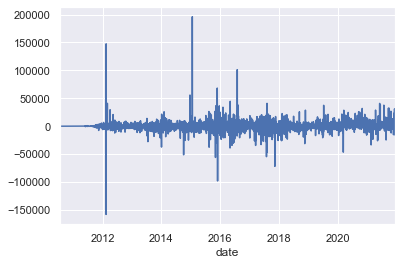

In [14]:
btc.NetFlowExNtv.plot()

In [15]:
df.shape

(2316, 2)

### Creating new Data- Returns and log Price

In [16]:
#Adding Log Price of btc and eth
logP1 = np.log(df['ethusd'])
df['logeth'] = logP1
logP = np.log(df['btcusd'])
df['logbtc'] = logP

#Adding Returns of btc and eth
df['returneth'] = df.ethusd.pct_change(1).mul(100)
df['returnbtc'] = df.btcusd.pct_change(1).mul(100)
df['sqreturnbtc'] = df.returnbtc.mul(df.returnbtc)
df['logret'] = np.log( df['btcusd'] / df['btcusd'].shift(1) ).mul(100)
df = df.iloc[1:] #Removing the first row as the return value would be null for it.
df.head()

,ethusd,btcusd,logeth,logbtc,returneth,returnbtc,sqreturnbtc,logret
date,,,,,,,,
2015-08-10,1.199990,264.928825,0.182313,5.579461,0.000000,-0.530594,0.281530,-0.532007
2015-08-11,0.990000,271.421736,-0.010050,5.603674,-17.499312,2.450813,6.006486,2.421263
2015-08-12,1.288000,268.143868,0.253091,5.591524,30.101010,-1.207666,1.458457,-1.215017
2015-08-13,1.884800,264.691628,0.633822,5.578565,46.335404,-1.287458,1.657549,-1.295818
2015-08-14,1.795044,266.355942,0.585030,5.584834,-4.762088,0.628775,0.395357,0.626806


In [17]:
df.tail()

,ethusd,btcusd,logeth,logbtc,returneth,returnbtc,sqreturnbtc,logret
date,,,,,,,,
2021-12-06,4341.941021,50535.425223,8.376077,10.830430,3.611918,2.449631,6.000691,2.420108
2021-12-07,4303.762652,50574.472834,8.367245,10.831202,-0.879293,0.077268,0.005970,0.077238
2021-12-08,4427.312634,50500.654351,8.395548,10.829742,2.870743,-0.145960,0.021304,-0.146067
2021-12-09,4157.287480,47937.822846,8.332618,10.777660,-6.099076,-5.074848,25.754083,-5.208148
2021-12-10,3931.613105,47437.228973,8.276805,10.767163,-5.428404,-1.044257,1.090472,-1.049747


## EDA

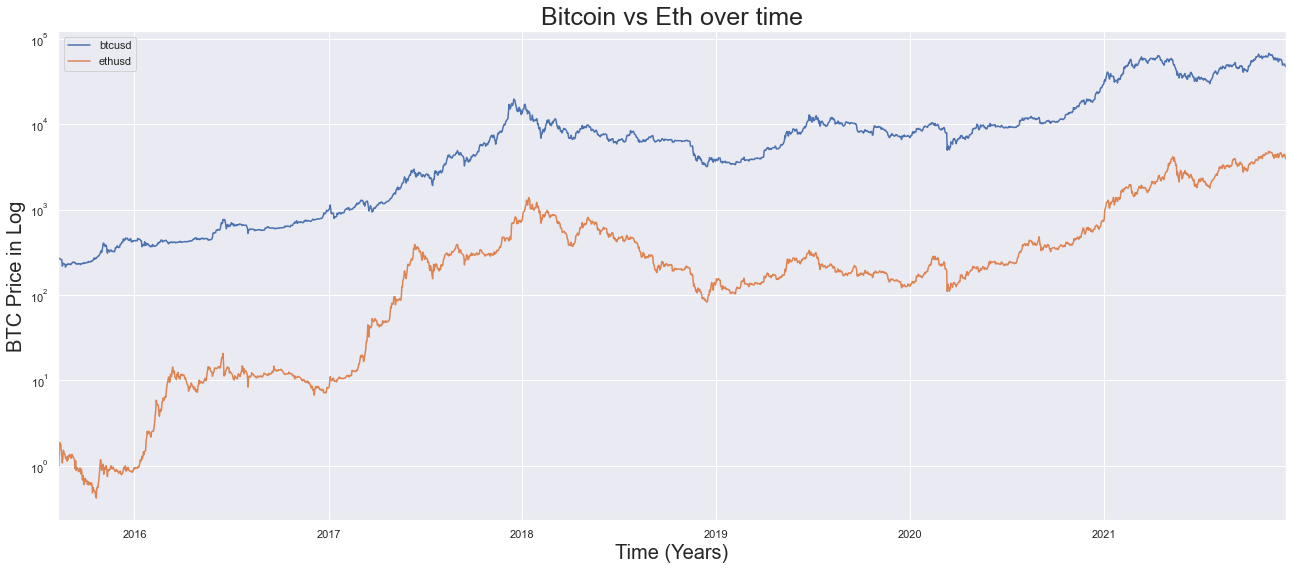

In [18]:
import matplotlib.pyplot as plt

df.plot( y = ["btcusd","ethusd"], logy = True, figsize=(22,9) )
plt.title("Bitcoin vs Eth over time", size=25)
plt.xlabel("Time (Years)", size=20)
plt.ylabel("BTC Price in Log", size=20)
plt.show()

Text(0, 0.5, 'Return (%)')

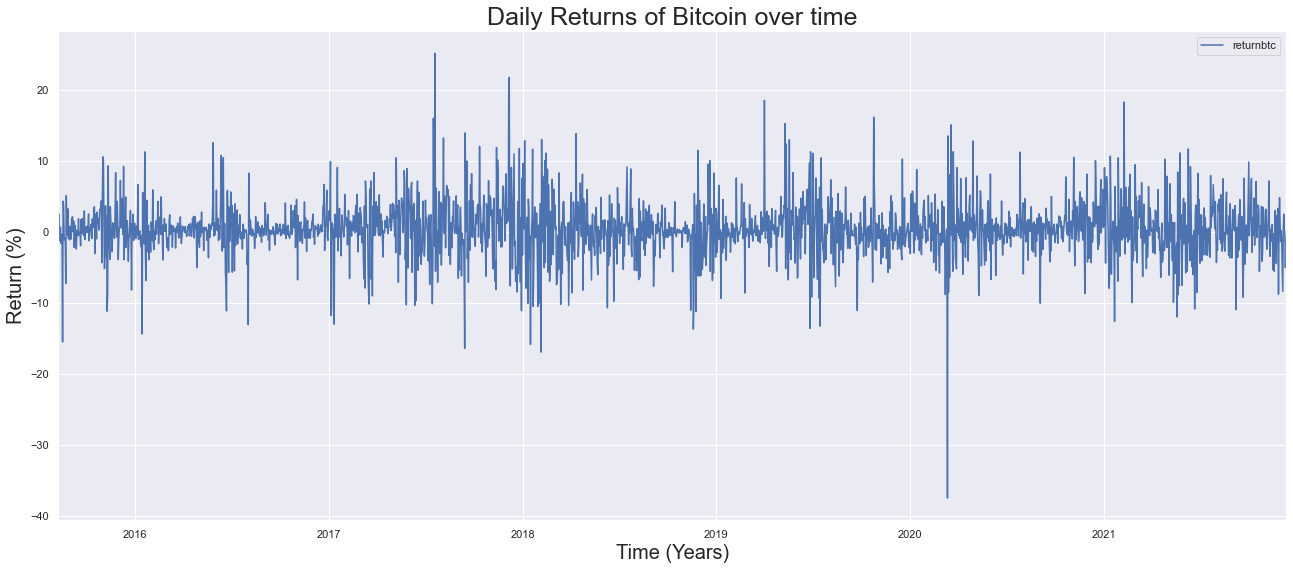

In [19]:
import matplotlib.pyplot as plt

df.plot(y='returnbtc', figsize=(22,9) )
plt.title("Daily Returns of Bitcoin over time", size=25)
plt.xlabel("Time (Years)", size=20)
plt.ylabel("Return (%)", size=20)


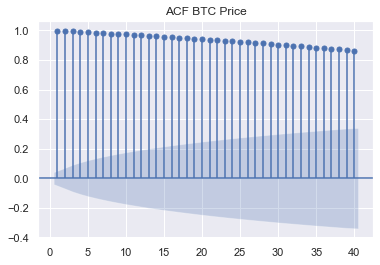

In [20]:
sgt.plot_acf(df.btcusd, lags = 40 , zero = False)
plt.title("ACF BTC Price" )
plt.show()

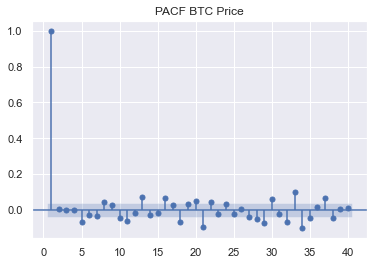

In [21]:
sgt.plot_pacf(df.btcusd, lags = 40 , zero = False, method = ('ols'))
plt.title("PACF BTC Price" )
plt.show()

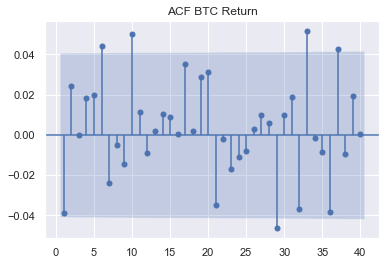

In [22]:
sgt.plot_acf(df.returnbtc, lags = 40 , zero = False)
plt.title("ACF BTC Return" )
plt.show()

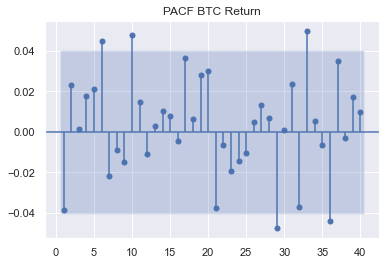

In [23]:
sgt.plot_pacf(df.returnbtc, lags = 40 , zero = False, method = ('ols'))
plt.title("PACF BTC Return" )
plt.show()

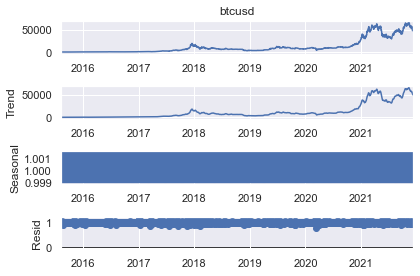

In [24]:
#Seasonality
sdecadd = seasonal_decompose(df.btcusd , model='multiplicative')
sdecadd.plot()
plt.show()

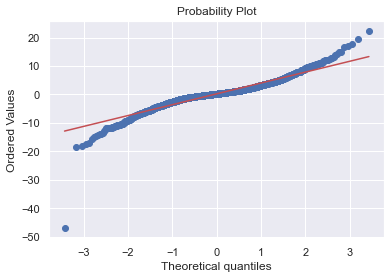

In [25]:
scipy.stats.probplot(df.logret,plot = pylab)  #QQ Plot
pylab.show()

In [26]:
sts.adfuller(df.logret) #Determing Covariance Stationarity (Dicker-Fuller test)

(-50.03924480930481,
 0.0,
 0,
 2314,
 {'1%': -3.4331791136300738,
  '5%': -2.862789843219427,
  '10%': -2.5674353474136984},
 12824.629855204083)

### Corelation between varios parameters with price  

In [27]:
print("Correlation of Price of BTC and ETH = ",df.btcusd.corr(df.ethusd))

Correlation of Price of BTC and ETH =  0.929674599866767


In [28]:
print("Corr of BTC Price and Active Address count = " ,btc.PriceUSD.corr(btc.AdrActCnt))

Corr of BTC Price and Active Address count =  0.6537043109858226


In [29]:
print("Corr of Mean Difficulty and Hash Rate = ",btc.DiffMean.corr(btc.HashRate))

Corr of Mean Difficulty and Hash Rate =  0.989717931113273


### Splitting the dataset

In [30]:
size = int(len(df)*0.8)
size

1852

In [31]:
train = df.iloc[:size]
test = df.iloc[size:]
train.tail()

,ethusd,btcusd,logeth,logbtc,returneth,returnbtc,sqreturnbtc,logret
date,,,,,,,,
2020-08-30,428.196438,11698.975833,6.059582,9.367257,6.950671,1.812008,3.283371,1.795786
2020-08-31,436.090769,11678.348227,6.077850,9.365492,1.843624,-0.176320,0.031089,-0.176475
2020-09-01,480.749176,11970.364856,6.175346,9.390189,10.240622,2.500496,6.252480,2.469745
2020-09-02,441.214134,11414.520934,6.089530,9.342642,-8.223632,-4.643500,21.562095,-4.754769
2020-09-03,383.542585,10261.494410,5.949451,9.236154,-13.071102,-10.101401,102.038301,-10.648783


Observations: 2315
Training Observations: 1852
Testing Observations: 463


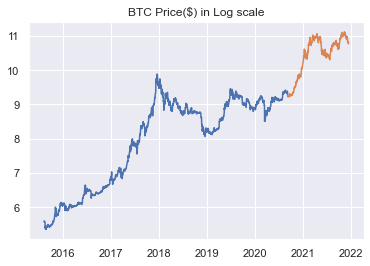

In [32]:
from matplotlib import pyplot

print('Observations: %d' % (len(df)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))
pyplot.plot(train.logbtc)
pyplot.plot(test.logbtc)
pyplot.title('BTC Price($) in Log scale')
pyplot.show()

### Time series Model- GARCH Model to Forecast Volatility

<AxesSubplot:xlabel='date'>

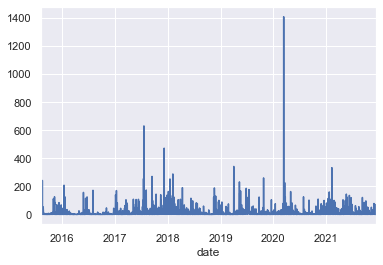

In [33]:
df.sqreturnbtc.plot() #Volatility 

In [34]:
rolling_predictions = []
test_size = 365

for i in range(test_size):
    train = df.logret[:-(test_size-i)]
    model = arch_model(train,mean = 'Constant' , vol = 'GARCH' , p = 1,q= 1, dist = 'Normal')
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1,reindex=True)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

In [35]:
rolling_predictions = pd.Series(rolling_predictions, index=df.index[-365:])

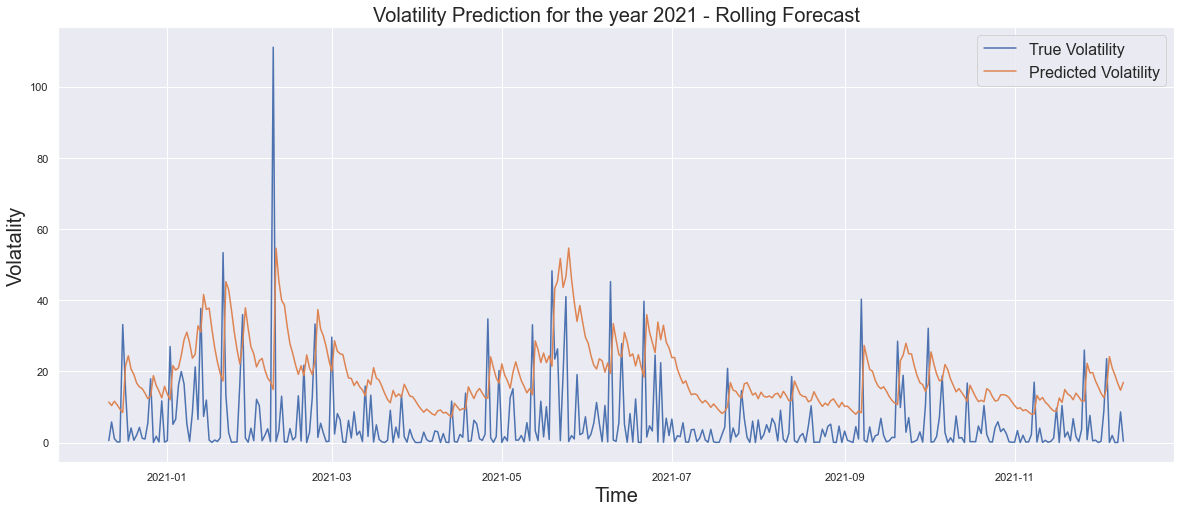

In [36]:
plt.figure(figsize=(20,8))
true, = plt.plot(df.sqreturnbtc[-365:].mul(1/3))
preds, = plt.plot(rolling_predictions.mul(rolling_predictions))
plt.title('Volatility Prediction for the year 2021 - Rolling Forecast', fontsize=20)
plt.xlabel("Time", size=20)
plt.ylabel("Volatality", size=20)
plt.legend(['True Volatility', 'Predicted Volatility'], fontsize=16)

In [37]:
print(f'R2: {r2_score(df.sqreturnbtc[-365:].mul(1/3), rolling_predictions.mul(rolling_predictions)):.2f}')
print(f'MAE: {mean_absolute_error(df.sqreturnbtc[-365:].mul(1/3), rolling_predictions.mul(rolling_predictions)):.2f}')
print(f'MSE: {mean_squared_error(df.sqreturnbtc[-365:].mul(1/3), rolling_predictions.mul(rolling_predictions)):.2f}')
print(f'EVS: {explained_variance_score(df.sqreturnbtc[-365:].mul(1/3), rolling_predictions.mul(rolling_predictions)):.2f}')

R2: -2.10
MAE: 15.43
MSE: 338.42
EVS: -0.59


In [38]:
from sklearn import preprocessing
normtrue = preprocessing.normalize([df.sqreturnbtc[-365:]])
normpred = preprocessing.normalize([rolling_predictions.mul(rolling_predictions)])

In [39]:
print(f'R2: {r2_score(normtrue[0],normpred[0]):.4f}')
print(f'MAE: {mean_absolute_error(normtrue,normpred):.2f}')
print(f'MSE: {mean_squared_error(normtrue,normpred):.4f}')
print(f'EVS: {explained_variance_score(normtrue,normpred):.2f}')

R2: -0.3992
MAE: 0.04
MSE: 0.0029
EVS: 1.00
